# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import os
import math
import warnings
warnings.filterwarnings('ignore')


import Bio
from Bio import Seq
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats

log = logging.getLogger()
WT = 'GCACAGGCGCAGACCGGCTGG'
tab10 = matplotlib.cm.get_cmap('tab10')
def set_pltrc():
    plt.rcParams["font.family"] = 'Helvetica'
    plt.rcParams['font.size'] = 9
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['figure.constrained_layout.use'] = True
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['figure.facecolor'] = 'w'
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['agg.path.chunksize'] = 10000
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)

set_pltrc()

def translate(s):
    return str(Seq.Seq(s).translate(table="Standard"))


In [2]:
barcodes_meta = pd.read_csv('../data/3p_utr/barcodes_200622/barcodes_metadata.tsv', sep='\t')
barcodes_map = barcodes_meta[['seq', 'pool_id']]
muscle_pool_ids = list(range(1, 17)) + [18]

def load_run_variants(run, construct, filename=None, load_all=False, num_bp=None, dtypes=None, sort_by=None,
                      sample_rename_fn=None):
    num_bp = num_bp if num_bp else 21
    sort_by = sort_by if sort_by is not None else 'rpm_ratio'
    variants_columns = ['sample', 'seq', 'num_reads', 'rpm', 'rpm_ratio']
    if load_all:
        sub = 'all'
    else:
        sub = 'filtered'

    df_dtypes = {'sample': 'category'}
    if dtypes is not None:
        df_dtypes.update(dtypes)

    if filename is None:
        filename = f'../runs/{run}/seqvar/{run}.{construct}.{sub}_variants.tsv.gz'

    df = pd.read_csv(filename, sep='\t', names=variants_columns, dtype=df_dtypes)

    df = df.sort_values(sort_by, ascending=False)
    df['tissue'] = df['sample'].str.split('_').str[-2].astype('category')
    df['nucl'] = df['sample'].str.split('_').str[-1].astype('category')
    df['subject'] = df['sample'].str.split('_').str[-3].astype('category')
    df['aa'] = df['seq'].str.pad(width=num_bp, side='right', fillchar='N').map(translate)

    df.loc[df['sample'].str.endswith('vL'), ['tissue', 'subject']] = np.nan
    df.loc[df['sample'].str.endswith('pL'), ['tissue', 'subject']] = np.nan

    if sample_rename_fn is not None:
        df['sample'] = sample_rename_fn(df['sample'])
    df['sample'] = df['sample'].astype('category')
    return df

def load_barcode_run(run_name, construct, load_all=None, annotate_func=None, 
                     metadata=None, filter_pool_ids=None, load_vl_only=False,
                     keep_unmatched=None):
    rv = load_run_variants(run_name, construct, load_all=load_all).drop_duplicates()
    del rv['aa']
    if load_vl_only:
        rv = rv[rv['sample'].str.contains('vL')]
    else:
        rv = rv[~rv['sample'].str.contains('vL')]
    rv['sample'] = rv['sample'].cat.remove_unused_categories()
    rv = merge_barcodes_missing(rv, barcodes_map, filter_pool_ids=filter_pool_ids,
                                keep_unmatched=keep_unmatched)
    if annotate_func is not None:
        rv = annotate_func(rv)
    if metadata is not None:
        rv = pd.merge(rv, metadata, on='sample', suffixes=('_auto', ''), how='left')
    return rv


def record_outliers(df, run_name=None, construct=None, fn=None):
    outliers = df.groupby(['pool_id', 'seq']).sum().reset_index()[['pool_id', 'seq', 'outlier']]
    outliers['outlier'] = outliers['outlier'].astype(bool)
    if fn is None:
        fn = f'../runs/{run_name}/analysis/{run_name}.{construct}.outlier_barcodes.tsv'
        fdir = f'../runs/{run_name}/analysis'
    os.makedirs(fdir, exist_ok=True)
    outliers.to_csv(fn, sep='\t', index=False)
    return outliers

def record_all_barcodes(df, run_name=None, construct=None, fn=None):
    if fn is None:
        fn = f'../runs/{run_name}/analysis/{run_name}.{construct}.all_barcodes.tsv.gz'
        fdir = f'../runs/{run_name}/analysis'
    else:
        fdir = os.path.dirname(fn)
    os.makedirs(fdir, exist_ok=True)
    subset = [
        'sample', 'pool_id', 'seq', 'subject', 'tissue', 'part', 'side', 'nucl', 'outlier', 'rpm', 'rpm_ratio'
    ]
    b = df[df.columns.intersection(subset)]
    b.to_csv(fn, sep='\t', index=False)
    return b

def record_pool_means(df, run_name=None, construct=None, fn=None):
    if fn is None:
        fn = f'../runs/{run_name}/analysis/{run_name}.{construct}.pool_means.tsv'
        fdir = f'../runs/{run_name}/analysis'
    else:
        fdir = os.path.dirname(fn)
    os.makedirs(fdir, exist_ok=True)
    subset = ['subject', 'sample', 'pool_id', 'tissue', 'part', 'side', 'nucl']
    subset = df.columns.intersection(subset).tolist()
    m = df[df['outlier'] == False].groupby(
            subset,
            dropna=False
        ).mean().reset_index()[subset + ['rpm', 'rpm_ratio']]
    m.to_csv(fn, sep='\t', index=False)
    return m

def plot_construct_mean_by_subject(
    df, xorder=None, metric='rpm_ratio', use_mean=True, outlier=False, 
    title_attr=None, ncols=2, attr_cols=None, attr_cols_required=None,
    mean_attr_cols=None, force_boxplot=False,
    hue=None, strip_hue=None, hue_order=None, strip_dodge=None,
    ytops={}, ytop_default=None, ybottom=None, 
    label_pool_id=None):
    assert metric in ('rpm', 'rpm_ratio')
    
    if attr_cols is None:
        attr_cols = ['tissue', 'nucl']
    if attr_cols_required is None:
        attr_cols_required = ['tissue']
    if mean_attr_cols is None:
        mean_attr_cols = ['sample', 'subject', 'pool_id', 'tissue']
    if strip_hue is None:
        strip_hue = 'subject'

    attrs = df[attr_cols].dropna(how='all', subset=attr_cols_required).drop_duplicates().reset_index().sort_values(by=attr_cols)
    nattrs = len(attrs)

    nrows = int(math.ceil(nattrs / ncols))
    cfig, caxs = plt.subplots(nrows, ncols, 
                              figsize=(6 * ncols, 4 * nrows))
    if len(attrs) == 1:
        pairs = zip(range(len(attrs)), [caxs])
    else:
        pairs = zip(range(len(attrs)), caxs.flatten())
    for i, cax in pairs:
        #fig, ax = plt.subplots(figsize=(8, 4))
        sdf = pd.merge(df, attrs.iloc[[i]], on=attr_cols)
        if not outlier:
            sdf = sdf[~sdf['outlier']]
        if use_mean:
            dfm = sdf.groupby(mean_attr_cols, dropna=False).mean().reset_index()
        else:
            dfm = sdf
        n_samples = len(dfm['sample'].unique())
        val_tup = list(attrs.iloc[i])
        title = '_'.join([str(x) for x in val_tup[1:] if not pd.isnull(x)])
        def splot(sax):
            if n_samples > 1 or force_boxplot:
                sns.stripplot(x='pool_id', y=metric, data=dfm, size=3, jitter=True, ax=sax, 
                              order=xorder, hue=strip_hue, hue_order=hue_order, dodge=strip_dodge)
                sns.boxplot(x='pool_id', y=metric, data=dfm, ax=sax, order=xorder, 
                            boxprops=dict(alpha=.3), hue=hue, color='#8c8c8c')
            else:
                sns.barplot(x='pool_id', y=metric, data=dfm, ax=sax, order=xorder) 
            sax.set_title(title)

            if ytop_default is not None:
                ytop = ytop_default
            else:
                ytop = None
            for key, key_ytop in ytops.items():
                if key in title:
                    ytop = key_ytop           
            sax.set_ylim(top=ytop, bottom=-0.2)
            if label_pool_id is not None:
                vytop = ytop if ytop is not None else max(dfm[metric])
                sax.text(0, vytop * 0.95, '{:.2f}'.format(dfm.loc[dfm['pool_id'] == label_pool_id, metric].median()), 
                         ha='center', va='center')
            if n_samples > 1:
                sax.legend(loc='upper right')
            if metric == 'rpm_ratio':
                sax.set_ylabel('RPM Ratio')
            elif metric == 'rpm':
                sax.set_ylabel('RPM')
            sax.set_xlabel('Pool #')
        splot(cax)
    return cfig, caxs

def plot_construct_vl(*args, **kwargs):
    kwargs['attr_cols'] = ['sample']
    kwargs['attr_cols_required'] = ['sample']
    kwargs['use_mean'] = False
    kwargs['force_boxplot'] = True
    kwargs['metric'] = 'rpm'
    kwargs['outlier'] = True
    kwargs['ncols'] = 1
    plot_construct_mean_by_subject(*args, **kwargs)


def plot_constructs_by_sample(df, xorder=None, metric='rpm_ratio', outlier=True):
    assert metric in ('rpm', 'rpm_ratio')
    
    samples = [x for x in sorted(df['sample'].unique()) if 'vL' not in x or metric == 'rpm']

    fig, axs = plt.subplots(len(samples), 1, figsize=(8, len(samples) * 4))
    for sample, ax in zip(samples, axs):
        if metric == 'rpm_ratio' and 'vL' in sample:
            continue
        sdf = df[(df['sample'] == sample)]
        if not outlier:
            sdf = sdf[~sdf['outlier']]
        sns.stripplot(x='pool_id', y=metric, data=sdf, size=3, jitter=True, ax=ax, order=xorder)
        sns.boxplot(x='pool_id', y=metric, data=sdf, ax=ax, order=xorder, boxprops=dict(alpha=.3))

        ax.set_title(sample)
        ax.set_xlabel('')
        metric_fn = '' if metric == 'rpm_ratio' else '.rpm'

def merge_barcodes_missing(df, barcodes_meta, filter_pool_ids=None, outlier=True,
                           keep_unmatched=False, vl=False):
    s = df[~df['sample'].str.isnumeric()]

    s['key'] = 1
    if filter_pool_ids is not None:
        bm = barcodes_meta[barcodes_meta['pool_id'].isin(filter_pool_ids)].copy()
    else:
        bm = barcodes_meta.copy()
    bm['key'] = 1
    
    prod = pd.merge(s[['sample', 'key']].drop_duplicates(), bm, on='key')
    del prod['key']

    if keep_unmatched:
        merge_strat = 'outer'
    else:
        merge_strat = 'right'
    
    mdf = pd.merge(df, barcodes_meta, how=merge_strat, on='seq').dropna(subset=['sample'])
    mdf = pd.merge(mdf, prod, on=['sample', 'pool_id', 'seq'], how=merge_strat)
    mdf['rpm'] = mdf['rpm'].fillna(0)
    mdf['rpm_ratio'] = mdf['rpm_ratio'].fillna(0)

    mdf['rank'] = mdf.groupby(['sample', 'pool_id'])['rpm_ratio'].rank(ascending=False)
    mdf['rpm_rank'] = mdf.groupby(['sample', 'pool_id'])['rpm'].rank(ascending=False)
    
    mdf['sample_outlier'] = ~((10 < mdf['rank']) & (46 > mdf['rank']))
    seqsum = mdf.groupby(['seq', 'pool_id'])['rpm_ratio'].sum().reset_index()
    seqsum['rank'] = seqsum.groupby('pool_id')['rpm_ratio'].rank(ascending=False)
    seqsum['outlier']= ~((10 < seqsum['rank']) & (46 > seqsum['rank']))
    mdf['outlier'] = mdf['seq'].isin(seqsum[seqsum['outlier']]['seq'])
    return mdf

# Mouse Muscle: 201009, 201011, 210122


In [3]:
def annotate_run_1011(rv):
    rv['tissue'] = rv['sample'].str.split('_').str[-2]
    rv['type'] = rv['sample'].str.split('_').str[0].str[1:]
    rv['sex'] = rv['sample'].str.split('_').str[0].str[0]

    rv['subject'] = rv['sample'].str.split('_').str[1]
    
    rv['ss'] = rv['sex'].astype(str) + '_' + rv['subject']
    rv['part'] = rv['sample'].str.split('_').str[-2]
    rv['nucl'] = rv['sample'].str.split('_').str[-1]
    return rv

# RNA data
hfxn_muscle_1009_raw = load_barcode_run(
    '201009', 'hFXN_Muscle', annotate_func=annotate_run_1011,
    filter_pool_ids=muscle_pool_ids)

# DNA data
hfxn_muscle_1011_raw = load_barcode_run(
    '201011', 'hFXN_Muscle', annotate_func=annotate_run_1011,
    filter_pool_ids=muscle_pool_ids)

# Excluded due to poor sequencing result
hfxn_muscle_1009 = hfxn_muscle_1009_raw[
    ~(hfxn_muscle_1009_raw['sample'].str.contains('MC57_R_Muscle_hFXN'))
]
hfxn_muscle_1011 = hfxn_muscle_1011_raw[
    ~(hfxn_muscle_1011_raw['sample'].str.contains('MC57_R_Muscle_hFXN'))
]


metadata_210122 = pd.read_csv('../runs/210122/metadata.210122.tsv', sep='\t', 
                              dtype={'subject': str})
# RNA data
hfxn_muscle_0122 = load_barcode_run(
    '210122', 'hFXN_Muscle', metadata=metadata_210122,
    filter_pool_ids=muscle_pool_ids)

record_outliers(hfxn_muscle_1009, run_name='201009', construct='hFXN_Muscle');

In [4]:
mouse_muscle = pd.concat([hfxn_muscle_1009, hfxn_muscle_1011, hfxn_muscle_0122], 
                    sort=False)

mouse_muscle.loc[mouse_muscle['tissue'] == 'QUA', 'tissue'] = 'Quad'
mouse_muscle.loc[mouse_muscle['tissue'] == 'HRT', 'tissue'] = 'Heart'
mouse_muscle.loc[mouse_muscle['tissue'] == 'GA', 'tissue'] = 'Gastroc'
mouse_muscle.loc[mouse_muscle['tissue'] == 'AB', 'tissue'] = 'Abdominal'
mouse_muscle.loc[mouse_muscle['tissue'] == 'TRI', 'tissue'] = 'Triceps'
mouse_muscle.loc[mouse_muscle['tissue'] == 'DIA', 'tissue'] = 'Diaphragm'
mouse_muscle.loc[mouse_muscle['tissue'] == 'LIV', 'tissue'] = 'Liver'
mouse_muscle.loc[mouse_muscle['tissue'] == 'KID', 'tissue'] = 'Kidney'
mouse_muscle.loc[mouse_muscle['tissue'] == 'LU', 'tissue'] = 'Lung'
mouse_muscle.loc[mouse_muscle['tissue'] == 'SPL', 'tissue'] = 'Spleen'

In [5]:
record_all_barcodes(
    mouse_muscle,
    fn='../analysis/hfxn_mouse_muscle/2010.hfxn_mouse_muscle.all_barcodes.tsv.gz')


record_pool_means(
    mouse_muscle,
    fn='../analysis/hfxn_mouse_muscle/2010.hfxn_mouse_muscle.pool_means.tsv');

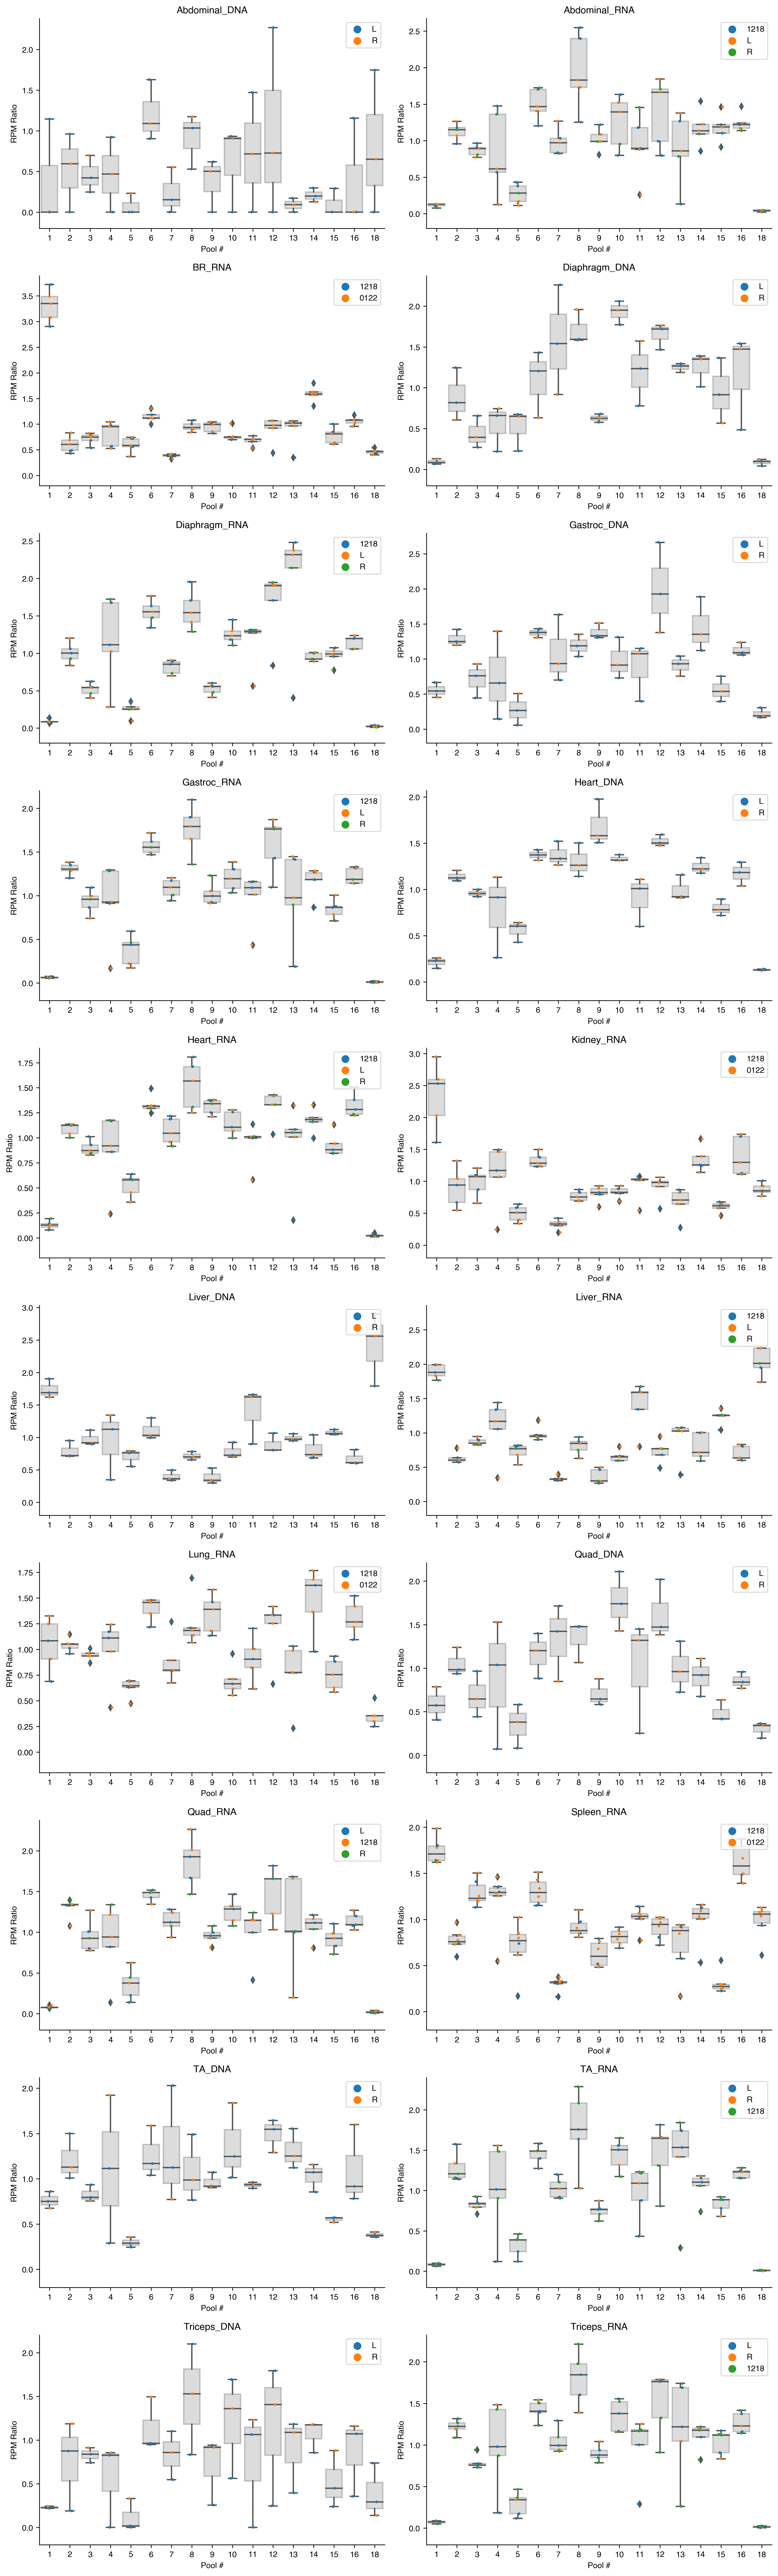

In [6]:
plot_construct_mean_by_subject(mouse_muscle);

## C57 Plot by sex & type

Text(0.5, 0.98, 'C57 RNA')

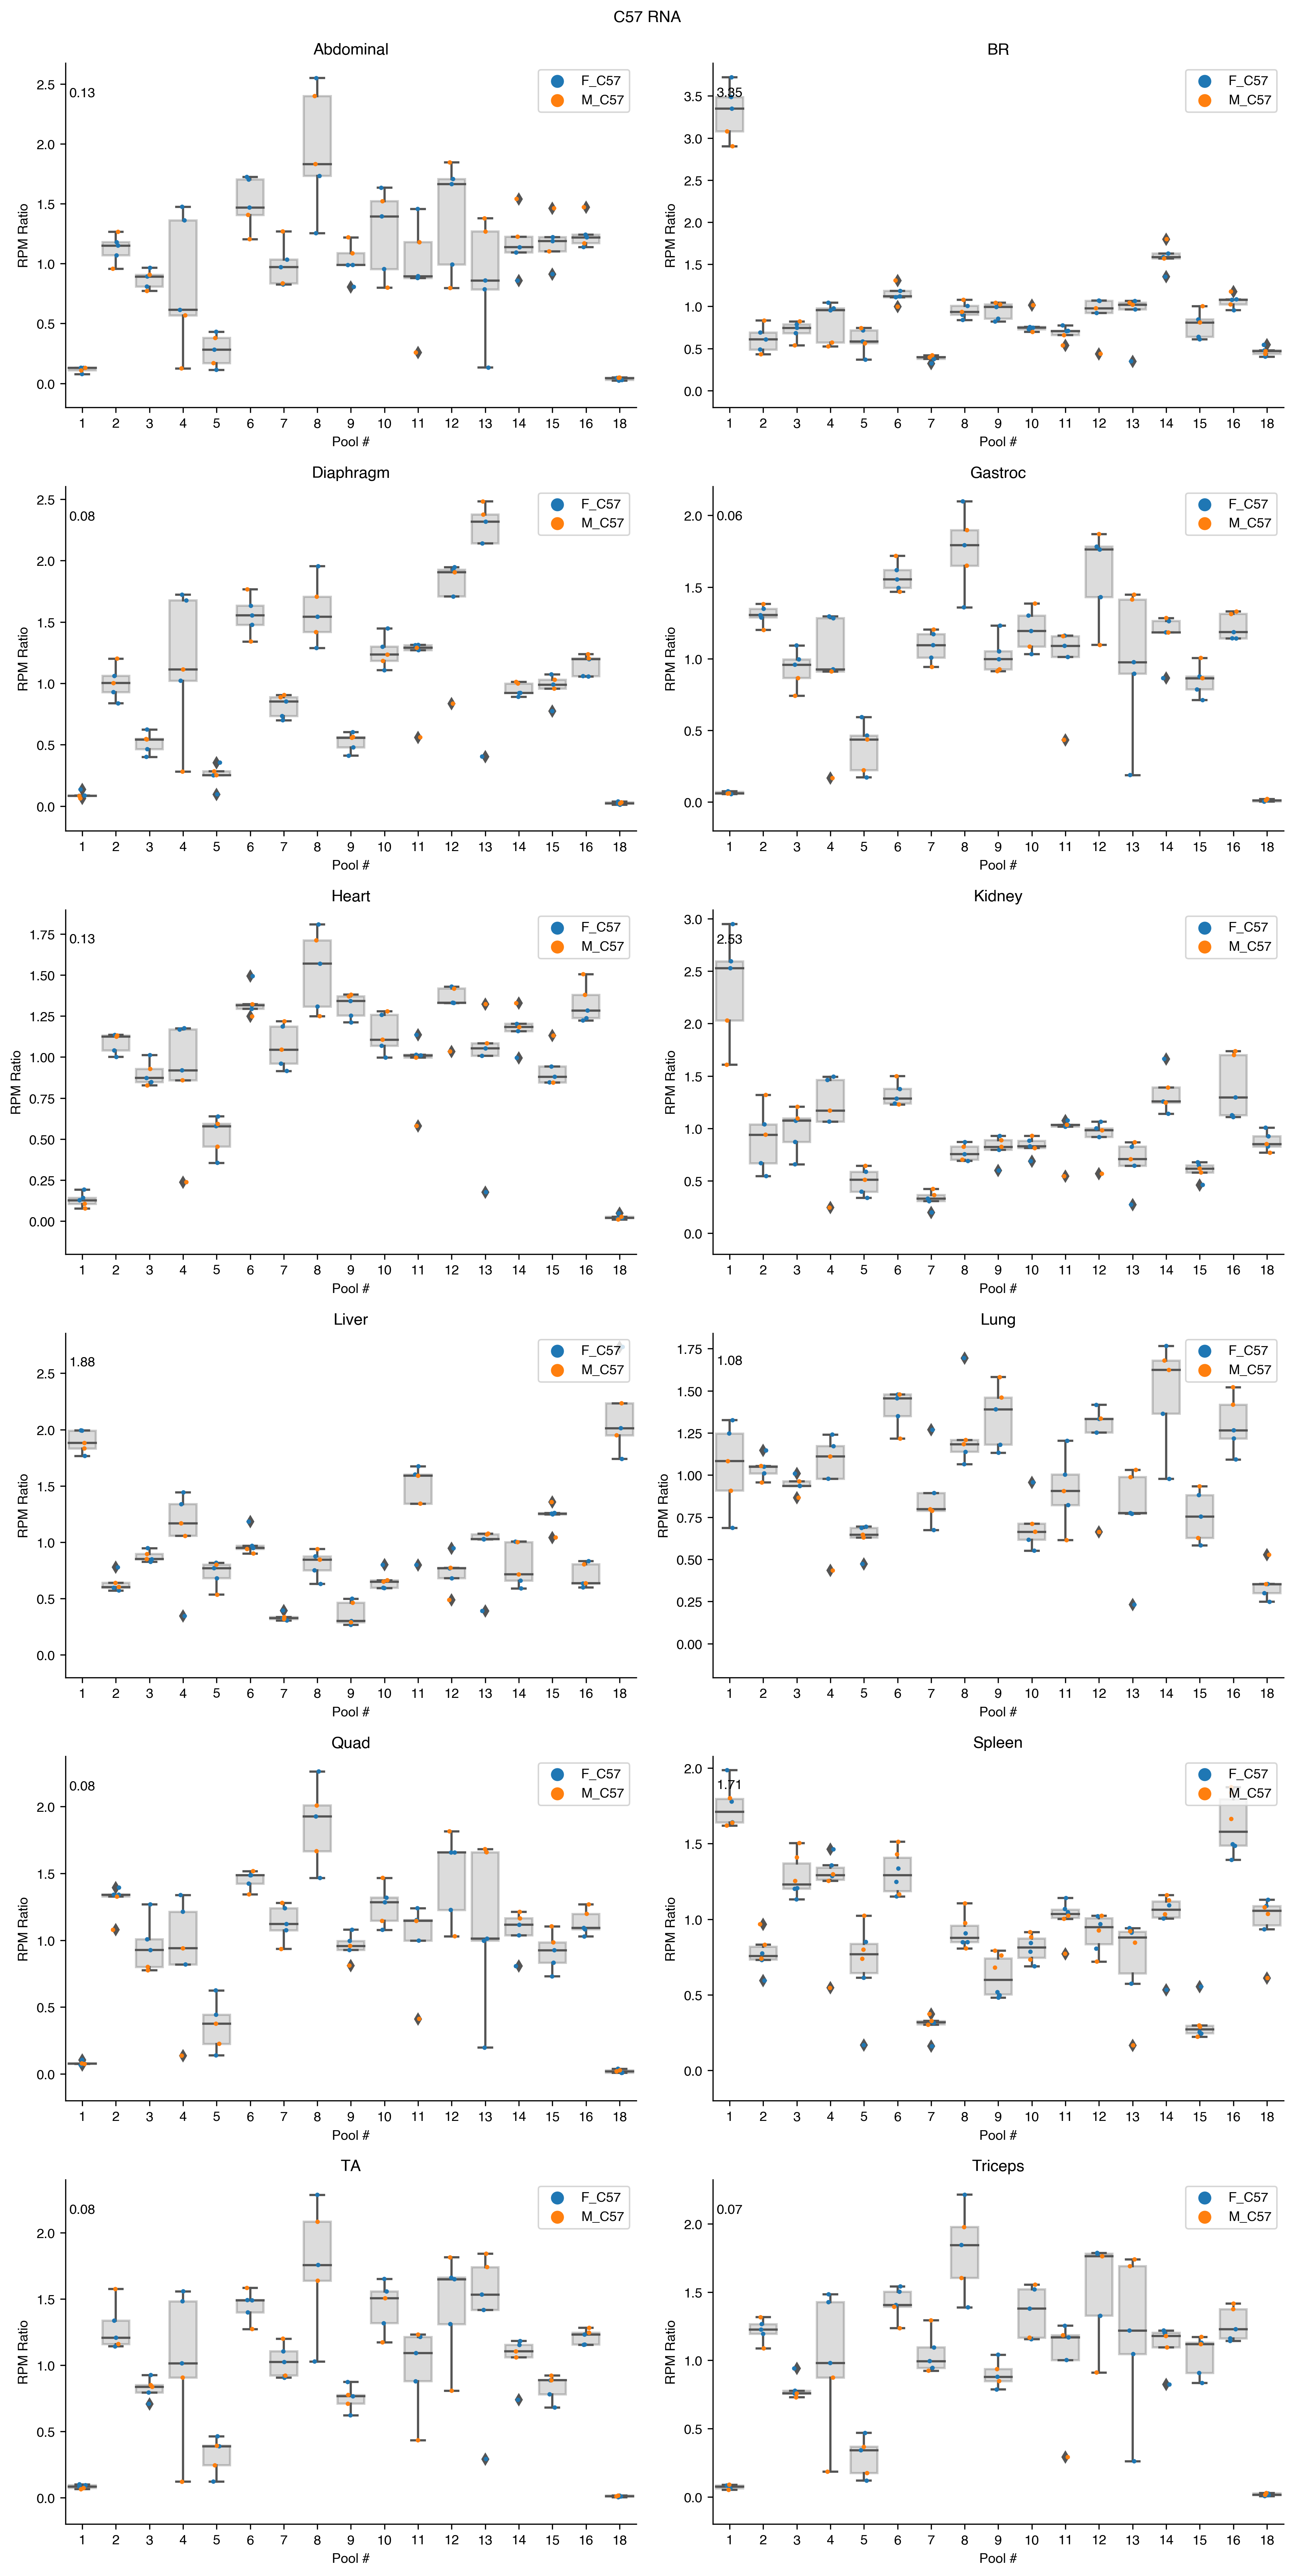

In [7]:
mouse_muscle['st'] = mouse_muscle['sex'] + '_' + mouse_muscle['type']
        
def plot_construct_mean_by_sextype(*args, **kwargs):
    kwargs['attr_cols'] = ['tissue']
    kwargs['attr_cols_required'] = ['tissue']
    kwargs['mean_attr_cols'] = ['sample', 'subject', 'pool_id', 'tissue', 'nucl', 'sex', 'type', 'st']
    kwargs['use_mean'] = True
    kwargs['strip_hue'] = 'st'
    return plot_construct_mean_by_subject(*args, **kwargs)

rna_mouse_muscle = mouse_muscle[(mouse_muscle['nucl'] == 'RNA')]
fig, axs = plot_construct_mean_by_sextype(
    rna_mouse_muscle,
    xorder=muscle_pool_ids, label_pool_id=1)
fig.suptitle('C57 RNA')

Text(0.5, 0.98, 'C57 DNA')

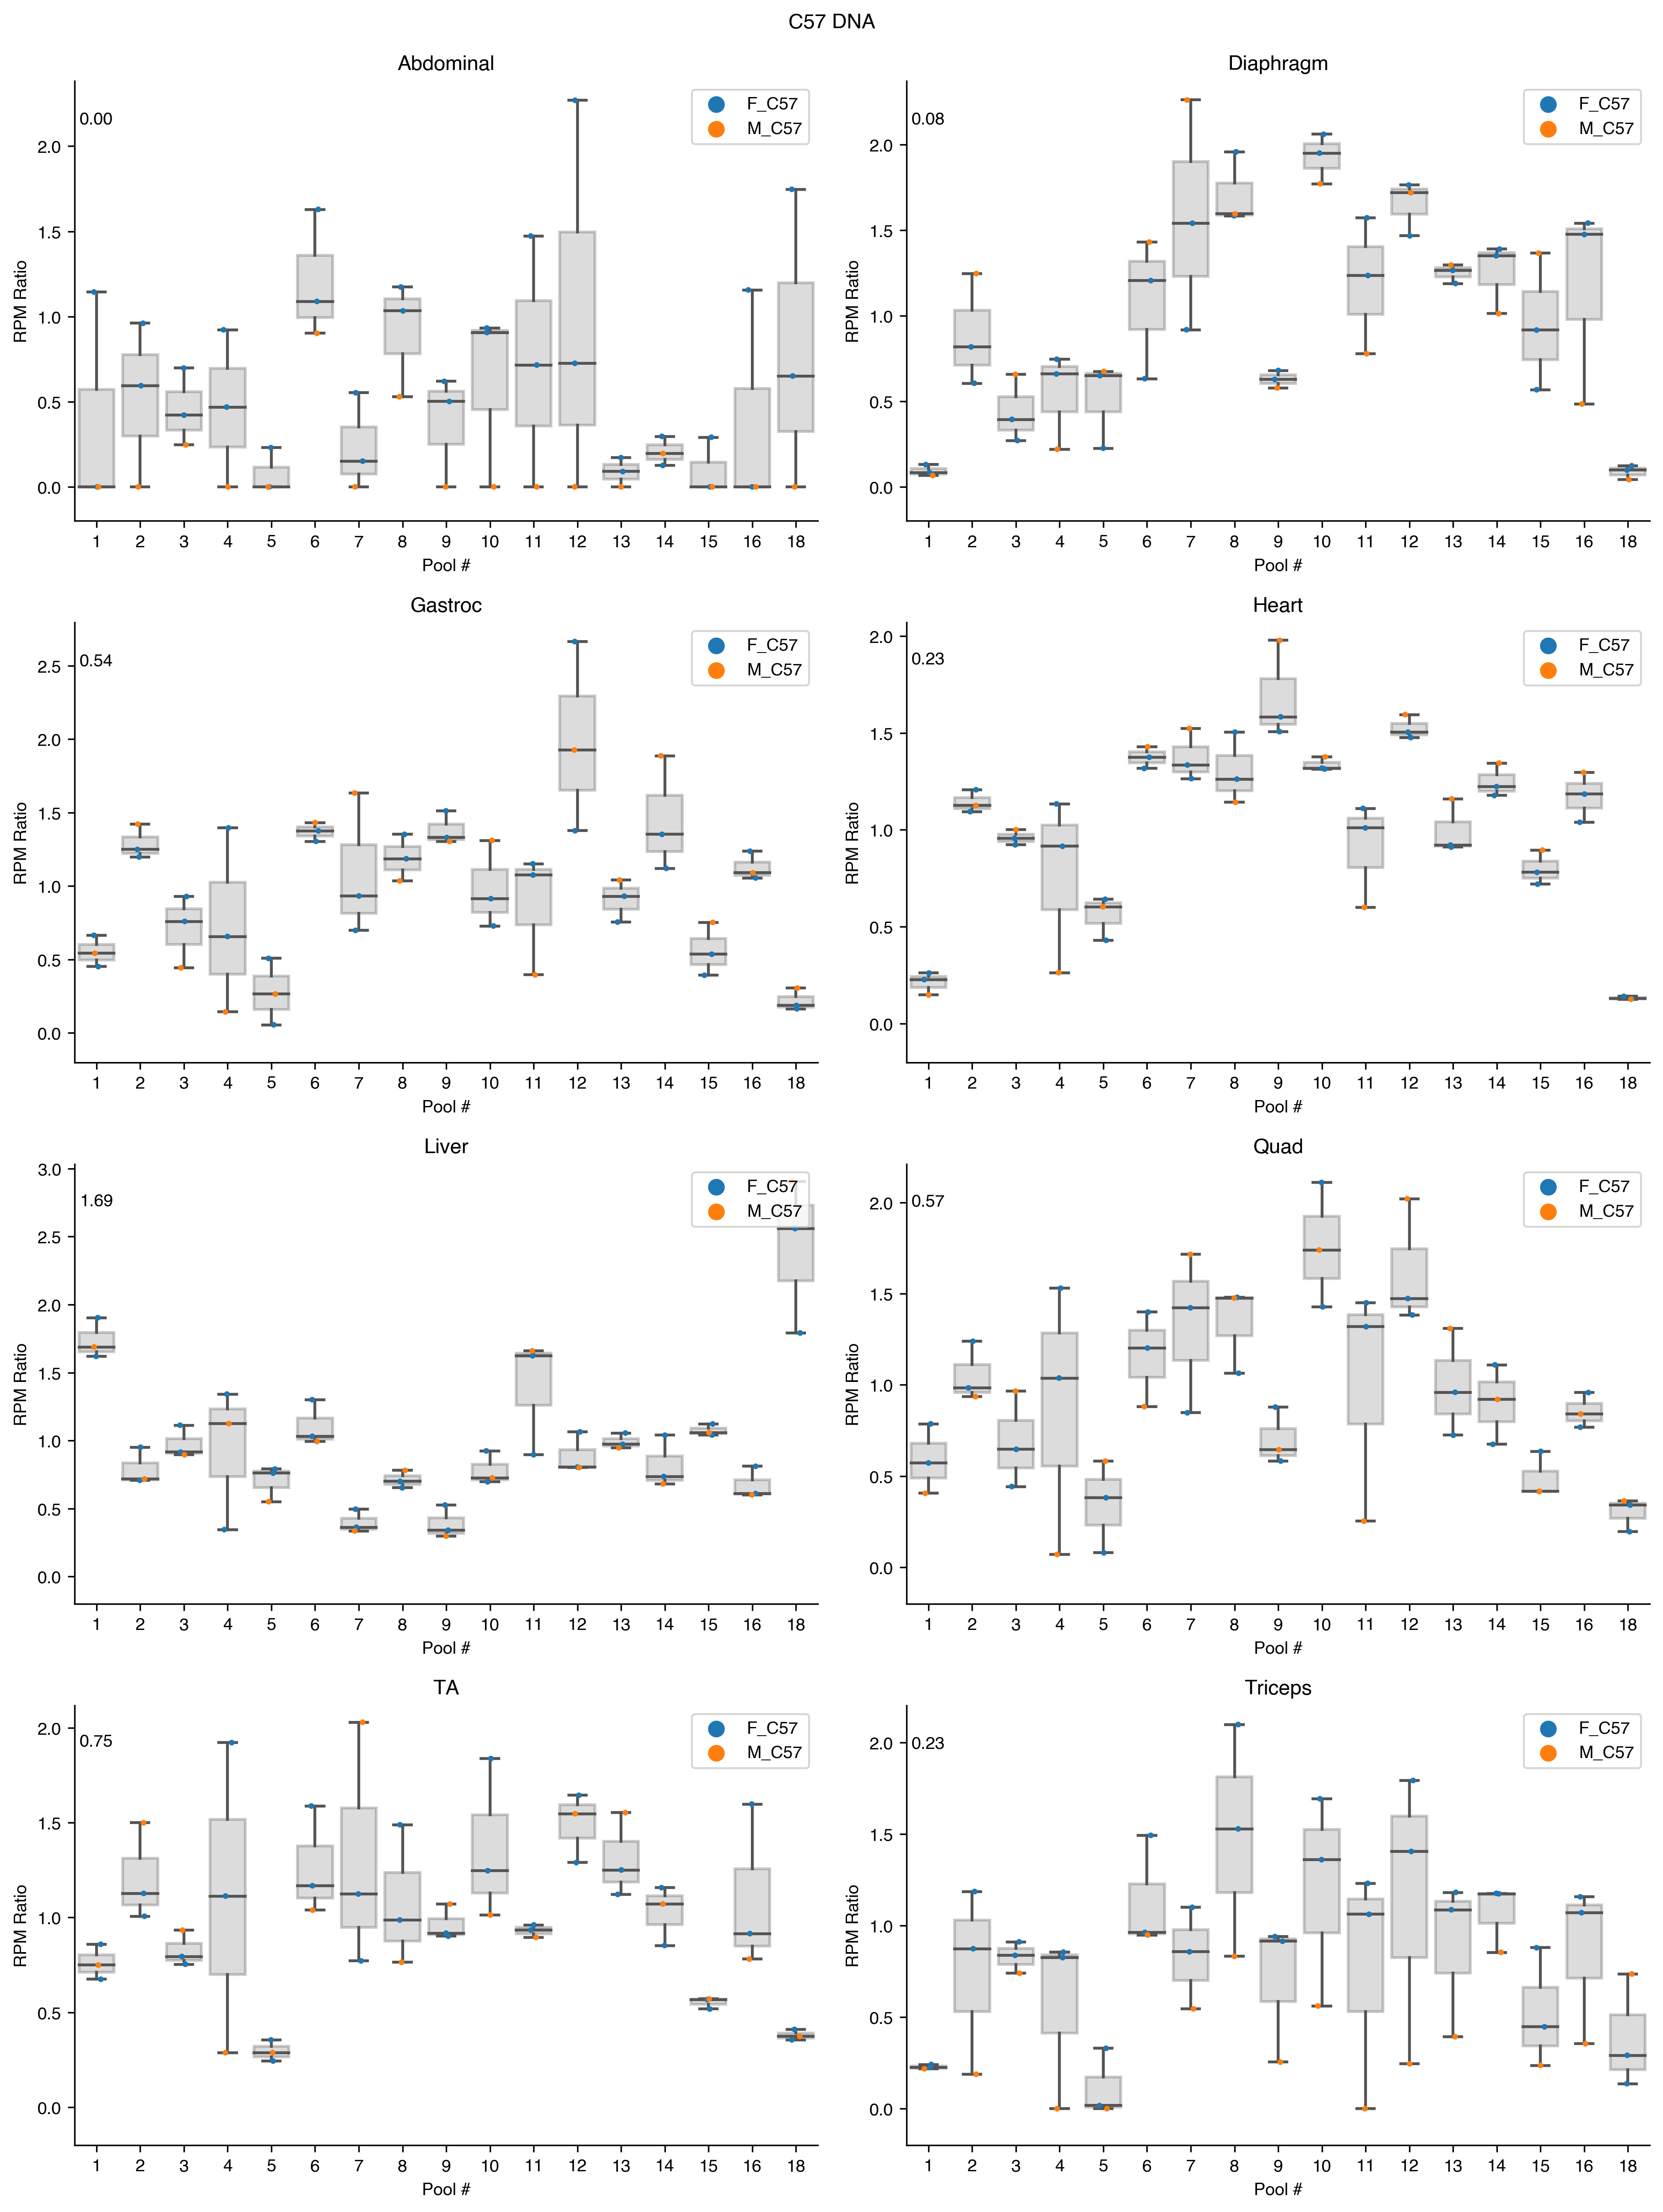

In [8]:
dna_mouse_muscle = mouse_muscle[(mouse_muscle['nucl'] == 'DNA')]

fig, axs = plot_construct_mean_by_sextype(
    dna_mouse_muscle,
    xorder=muscle_pool_ids, label_pool_id=1)
fig.suptitle('C57 DNA')

#  NHP Muscle RNA: 201024, 201106

In [9]:
def annotate_run_1024(rv):
    rv['type'] = rv['sample'].str.split('_').str[0].str[1:]

    rv['subject'] = rv['sample'].str.split('_').str[0]
    rv['nucl'] = rv['sample'].str.split('_').str[-1]
    
    rv['tp'] = rv['sample'].str.split('_').str[3:-1].str.join('_')
    rv['tissue'] = rv['tp']
    btissue = rv['sample'].str.split('_').str[3]

    rv.loc[rv['tp'].str.contains('_\d'), 'tissue'] = rv.loc[rv['tp'].str.contains('\d'), 'tp'].str.split('_').str[:-1].str.join('_')
    rv.loc[rv['tp'].str.contains('L_|R_'), 'side'] = rv.loc[rv['tp'].str.contains('L_|R_'), 'tp'].str[0]
    rv.loc[rv['tp'].str.contains('L_|R_'), 'tissue'] = rv.loc[rv['tp'].str.contains('L_|R_'), 'tissue'].str.split('_').str[1:].str.join('_')
    rv.loc[rv['sample'].str.contains('vL'), 'tissue'] = np.nan

    return rv
                 

hfxn_muscle_1024 = load_barcode_run(
    '201024', 'hFXN_Muscle', annotate_func=annotate_run_1024,
    filter_pool_ids=muscle_pool_ids)
record_outliers(hfxn_muscle_1024, run_name='201024', construct='hFXN_Muscle');

In [10]:

hfxn_muscle_1106 = load_barcode_run(
    '201106', 'hFXN_Muscle', metadata=pd.read_csv('../runs/201106/metadata.201106.tsv', sep='\t'),
    filter_pool_ids=muscle_pool_ids)
record_outliers(hfxn_muscle_1106, run_name='201106', construct='hFXN_Muscle');

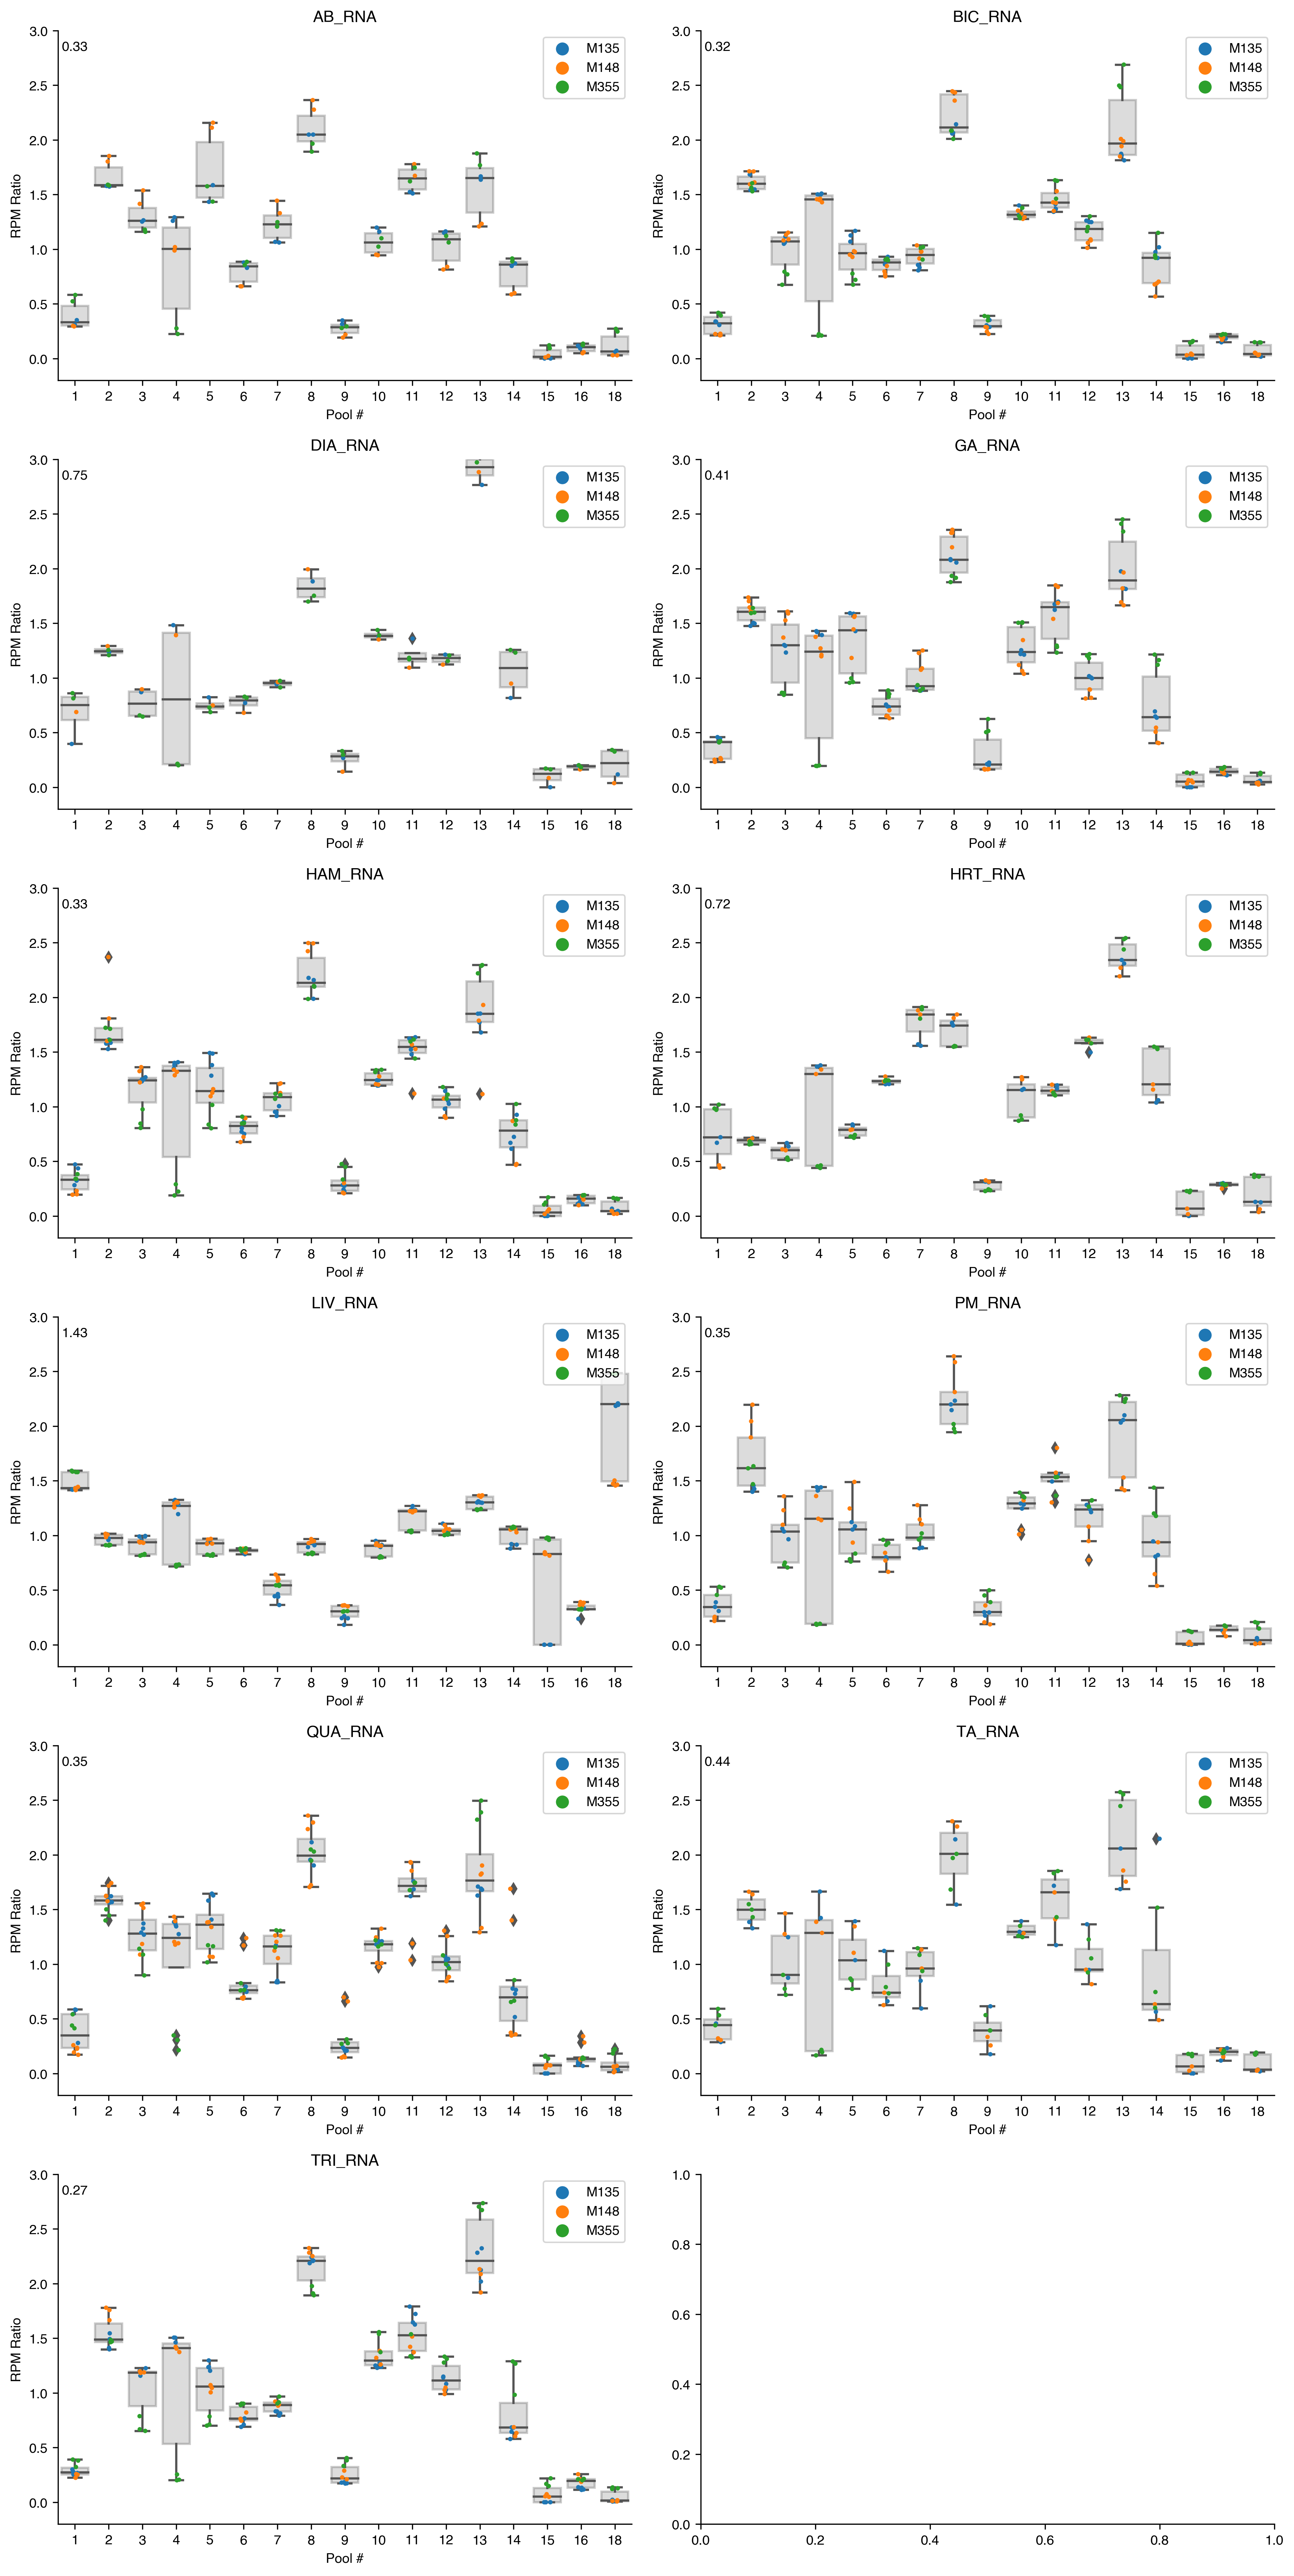

In [11]:
nhp_muscle = pd.concat([hfxn_muscle_1024, hfxn_muscle_1106])
plot_construct_mean_by_subject(
    nhp_muscle, xorder=muscle_pool_ids, title_attr='Muscle Variants', outlier=False,
    ytops={}, label_pool_id=1, ytop_default=3);


In [12]:
record_all_barcodes(
    nhp_muscle,
    fn='../analysis/hfxn_nhp_muscle_rna/2011.hfxn_nhp_muscle_rna.all_barcodes.tsv.gz')


record_pool_means(
    nhp_muscle,
    fn='../analysis/hfxn_nhp_muscle_rna/2011.hfxn_nhp_muscle_rna.pool_means.tsv');


#  NHP Organs RNA: 201113

In [13]:
def annotate_run_1113(rv):
    rv['subject'] = rv['sample'].str.split('_').str[0]
    rv['nucl'] = rv['sample'].str.split('_').str[-1]
    rv['tissue'] = rv['sample'].str.split('_').str[1]
    rv.loc[rv['sample'].str.contains('vL'), 'tissue'] = np.nan
    rv.loc[rv['sample'].str.contains('vL'), 'subject'] = 'vL'
    rv.loc[rv['sample'].str.contains('vL'), 'nucl'] = 'DNA'
    return rv


hfxn_organs_1113 = load_barcode_run(
    '201113', 'hFXN_Muscle', annotate_func=annotate_run_1113,
    filter_pool_ids=muscle_pool_ids)
record_outliers(hfxn_organs_1113, run_name='201113', construct='hFXN_Muscle');

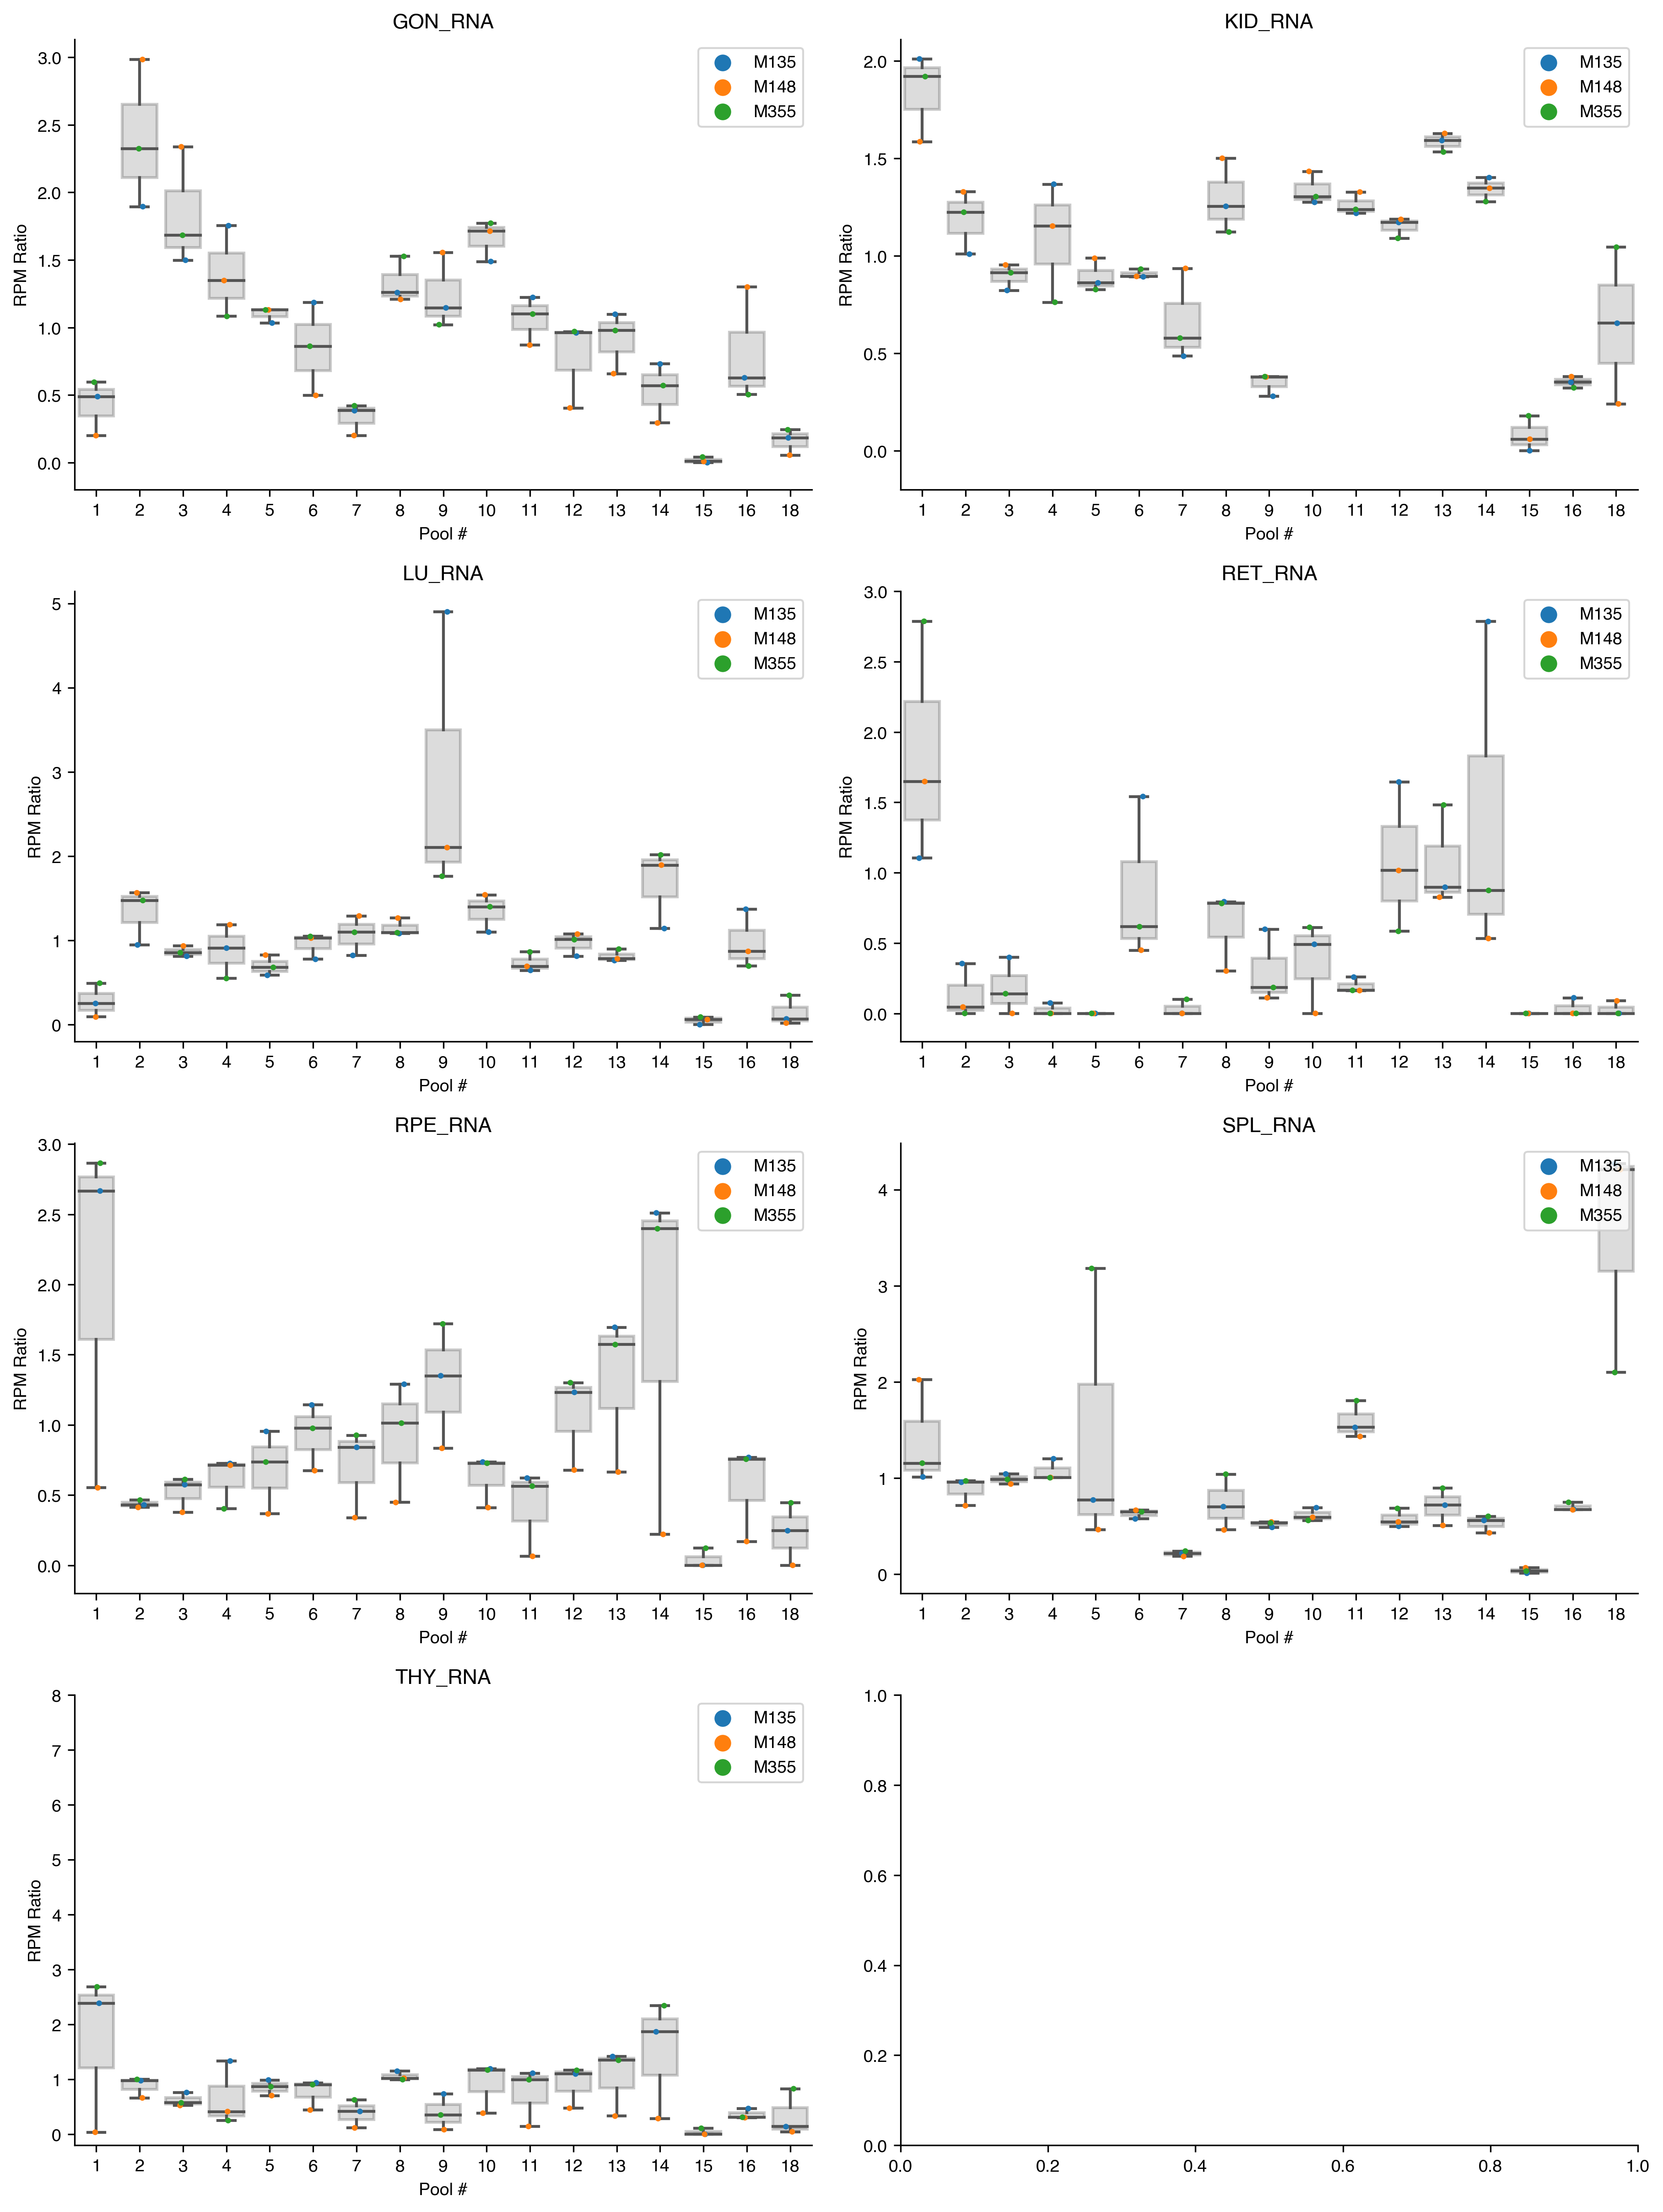

In [14]:
plot_construct_mean_by_subject(
    hfxn_organs_1113, xorder=muscle_pool_ids, title_attr='Muscle', outlier=False,
    ytops={'default': 5, 'RET': 3, 'THY': 8});


In [15]:
record_all_barcodes(
    hfxn_organs_1113, run_name='201113', construct='hFXN_Muscle')
record_pool_means(
    hfxn_organs_1113, run_name='201113', construct='hFXN_Muscle');